### JOB MATCHER FOR RESUME

Have you ever been unsure if your resume matches the job you're applying for? Do you have all the key words in your resume to pass the initial resume screening round? If not, this program is just for you! 

With the current job market being so competitve, your resume needs to be nearly perfect and match every job you apply for to even get a chance to interview. In this notebook, I created a program that allows you to upload your resume and the job description and determine how well your resume matches the description and what words you are missing.

In [10]:
# import packages
import pdfplumber
import docx
import re
from sentence_transformers import SentenceTransformer, util
import textstat
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
nltk.download('punkt_tab')

model = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/riyamhatre/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Now I need to get the text from my resume. Using the file path I put in, I extract the text and store it.

In [11]:
def extract_text(filepath):
    if filepath.endswith(".pdf"):
        with pdfplumber.open(filepath) as pdf:
            return "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())
    elif filepath.endswith(".docx"):
        doc = docx.Document(filepath)
        return "\n".join(p.text for p in doc.paragraphs)
    elif filepath.endswith(".txt"):
        with open(filepath, "r", encoding="utf-8") as f:
            return f.read()
    else:
        raise ValueError("Unsupported file type")

After getting the text from the resume, we have to extract the key words and remove irrelevant characters and stopwords. 

In [12]:
def extract_keywords(text):
    return set(re.findall(r'\b[a-zA-Z]{3,}\b', text.lower()))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    return ' '.join(w for w in word_tokens if w.lower() not in stop_words and w not in string.punctuation)


After cleaning up text, we can compare the resume text to the job description. Using cosine similarity and the sentence transformer model, we can compare the two texts and figure out how similar they are. In addition, we can figure out the most important words in the text and what words are/aren't matching.

In [16]:
def analyze_resume(resume_path, jd):
    resume_text = extract_text(resume_path).replace('\n', ' ')
    jd_text = jd
    resume_text = remove_stopwords(resume_text)
    jd_text = remove_stopwords(jd_text)
    # Semantic similarity
    resume_vec = model.encode(resume_text)
    jd_vec = model.encode(jd_text)
    similarity = util.cos_sim(resume_vec, jd_vec).item()

    # Keyword comparison
    resume_keywords = extract_keywords(resume_text)
    jd_keywords = extract_keywords(jd_text)

    common = resume_keywords & jd_keywords
    missing = jd_keywords - resume_keywords
    match_score = 100 * len(common) / len(jd_keywords) if jd_keywords else 0


    # Readability
    readability = textstat.flesch_reading_ease(resume_text)

    # Results
    results =  {
        "semantic_similarity": round(similarity * 100, 2),
        "keyword_match_score": round(match_score, 2),
        "common_keywords": sorted(common),
        "missing_keywords": sorted(missing),
        "readability_score": round(readability, 2)
    }

    return results

Now we check the results!

In [17]:
a = analyze_resume('/Users/riyamhatre/Desktop/mhatre_riya_resume.pdf','''Direct experience writing complex queries in SQL from scratch
Strong data visualization skills using Power BI, Tableau, Looker, or equivalent
Exposure to Azure Data Warehouse
Preferrably experienced with statistical programming languages such as R, Python, etc.
 Experience in analytics, advanced analytics/statistics, predictive modeling
 Strong analytic skills with the ability to extract, collect, organize, analyze and interpret trends or patterns in complex data sets
 Demonstrated project management skills
 Effective interpersonal, verbal and written communication skills''')

a

{'semantic_similarity': 52.52,
 'keyword_match_score': 38.78,
 'common_keywords': ['analytics',
  'data',
  'effective',
  'experience',
  'languages',
  'management',
  'modeling',
  'power',
  'predictive',
  'project',
  'python',
  'skills',
  'sql',
  'statistical',
  'tableau',
  'trends',
  'using',
  'visualization',
  'writing'],
 'missing_keywords': ['ability',
  'advanced',
  'analytic',
  'analyze',
  'azure',
  'collect',
  'communication',
  'complex',
  'demonstrated',
  'direct',
  'equivalent',
  'etc',
  'experienced',
  'exposure',
  'extract',
  'interpersonal',
  'interpret',
  'looker',
  'organize',
  'patterns',
  'preferrably',
  'programming',
  'queries',
  'scratch',
  'sets',
  'statistics',
  'strong',
  'verbal',
  'warehouse',
  'written'],
 'readability_score': -46.24}

In [27]:
def plot_scores(results):
    labels = []
    values = []
    colors = []

    for k in ['semantic_similarity', 'keyword_match_score', 'readability_score']:
        labels.append(k.replace('_', ' ').title())
        val = results[k]
        values.append(val)
        # Color based on positivity
        colors.append('green' if val >= 0 else 'red')

    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels, values, color=colors)
    
    # Set y-limits dynamically to show negative values
    y_min = min(0, min(values) - 20)
    y_max = max(values) + 10
    plt.ylim(y_min, y_max)
    
    plt.title("Resume Analysis Scores")
    
    # Annotate bar values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + (2 if height >= 0 else -6),
                 f"{height:.2f}", ha='center', va='bottom' if height >= 0 else 'top')

    plt.axhline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


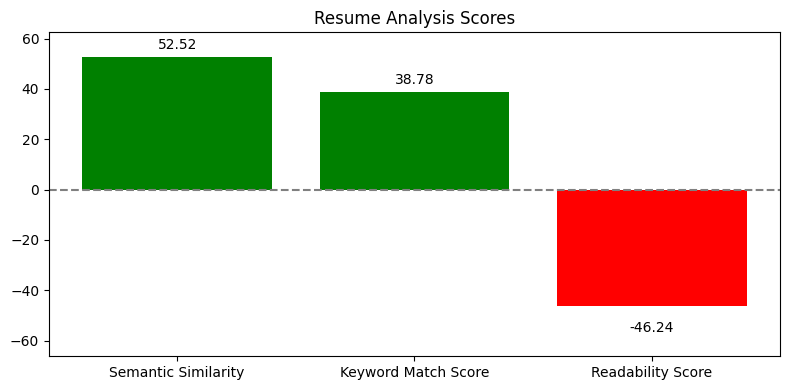

In [28]:
plot_scores(a)

In [22]:
from IPython.display import Markdown, display

def show_keywords(common_keywords, missing_keywords):
    display(Markdown("### ✅ Common Keywords:"))
    display(Markdown(", ".join(f"`{k}`" for k in common_keywords)))
    
    display(Markdown("### ❌ Missing Keywords:"))
    display(Markdown(", ".join(f"`{k}`" for k in missing_keywords)))


In [24]:
show_keywords(a['common_keywords'], a['missing_keywords'])

### ✅ Common Keywords:

`analytics`, `data`, `effective`, `experience`, `languages`, `management`, `modeling`, `power`, `predictive`, `project`, `python`, `skills`, `sql`, `statistical`, `tableau`, `trends`, `using`, `visualization`, `writing`

### ❌ Missing Keywords:

`ability`, `advanced`, `analytic`, `analyze`, `azure`, `collect`, `communication`, `complex`, `demonstrated`, `direct`, `equivalent`, `etc`, `experienced`, `exposure`, `extract`, `interpersonal`, `interpret`, `looker`, `organize`, `patterns`, `preferrably`, `programming`, `queries`, `scratch`, `sets`, `statistics`, `strong`, `verbal`, `warehouse`, `written`